# **FinBERT KURULUMU**

In [5]:
#!pip install transformers torch
# =============================================================================
# BLOK 1: SİSTEM KURULUMU VE HİBRİT MOTOR (LSTM + FINBERT)
# =============================================================================
# Eğer hata alırsan şu komutu çalıştır: !pip install transformers torch

import pandas as pd
import numpy as np
import joblib
import os
from tensorflow.keras.models import load_model
from transformers import pipeline # Yapay Zeka Haber Okuyucusu

print("⏳ Sistem Başlatılıyor...")

# 1. ESKİ DOSTLAR (Teknik Analiz Dosyaları)
DATA_PATH = 'stocks_hazir_veri.csv'
MODEL_PATH = 'neuroquant_lstm.h5'
SCALER_PATH = 'scaler.pkl'

# Dosya Kontrolü
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError("❌ HATA: LSTM Modeli bulunamadı! Notebook 2'yi çalıştırdın mı?")

print("📥 Teknik Model (LSTM) ve Veriler yükleniyor...")
df = pd.read_csv(DATA_PATH, index_col='Date', parse_dates=True)
model = load_model(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
print("✅ Teknik Beyin Hazır.")

# 2. YENİ TRANSFER (Sentiment Analizi - FinBERT)
print("🧠 FinBERT (Duygu Analiz Modeli) indiriliyor... (Bu biraz sürebilir)")

# HuggingFace'ten finans için eğitilmiş özel modeli çekiyoruz
# Bu model cümleleri okuyup 'Positive', 'Neutral', 'Negative' etiketi basar.
sentiment_analyzer = pipeline("sentiment-analysis", model="yiyanghkust/finbert-tone")

print("✅ FinBERT başarıyla yüklendi ve göreve hazır!")
print("-" * 40)
print(f"📊 Veri Seti Son Tarih: {df.index[-1]}")

⏳ Sistem Başlatılıyor...
📥 Teknik Model (LSTM) ve Veriler yükleniyor...
✅ Teknik Beyin Hazır.
🧠 FinBERT (Duygu Analiz Modeli) indiriliyor... (Bu biraz sürebilir)


Device set to use cpu


✅ FinBERT başarıyla yüklendi ve göreve hazır!
----------------------------------------
📊 Veri Seti Son Tarih: 2025-12-31 00:00:00


# **TEST AŞAMASI**

In [6]:
# =============================================================================
# BLOK 2: FINBERT TEST SÜRÜŞÜ (LABORATUVAR)
# =============================================================================
print("🧪 Laboratuvar Testi Başlıyor...\n")

# 1. Sentetik Haber Başlıkları (İngilizce olmak zorunda çünkü model İngilizce)
test_headlines = [
    "NVIDIA reports record-breaking revenue and launches new AI chip.",  # Senaryo A: Süper Haber
    "Tech sector crashes as inflation data disappoints investors.",      # Senaryo B: Felaket Haber
    "NVIDIA announces the date for the next shareholder meeting."        # Senaryo C: Nötr Haber (Rutini)
]

# 2. Analiz Yap
print(f"{'HABER BAŞLIĞI':<60} | {'DUYGU':<10} | {'GÜÇ (SKOR)'}")
print("-" * 85)

for headline in test_headlines:
    # FinBERT'e soruyoruz
    result = sentiment_analyzer(headline)[0]

    label = result['label'] # Positive, Negative, Neutral
    score = result['score'] # 0.0 ile 1.0 arası bir sayı (Ne kadar emin?)

    print(f"{headline:<60} | {label:<10} | {score:.4f}")

print("\n✅ Test tamamlandı. FinBERT mantıklı cevaplar veriyor mu?")

🧪 Laboratuvar Testi Başlıyor...

HABER BAŞLIĞI                                                | DUYGU      | GÜÇ (SKOR)
-------------------------------------------------------------------------------------
NVIDIA reports record-breaking revenue and launches new AI chip. | Positive   | 1.0000
Tech sector crashes as inflation data disappoints investors. | Negative   | 1.0000
NVIDIA announces the date for the next shareholder meeting.  | Neutral    | 0.9999

✅ Test tamamlandı. FinBERT mantıklı cevaplar veriyor mu?


In [8]:
# =============================================================================
# BLOK 3: FIRLATMA RAMPASI VE BIAS (HATA) HESAPLAMA
# =============================================================================
print("🚀 Gelecek tahmini için hazırlıklar yapılıyor...")

# 1. Son 60 Günü Al (Rampa)
features = ['Close', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower']
last_60_days = df[features].iloc[-60:].values # Ham veriler

# 2. Ölçekleme (Scaling)
# Geleceği tahmin ederken bu 'current_batch' sürekli güncellenecek
current_batch = scaler.transform(last_60_days)
# Model (1, 60, 5) formatı ister
current_batch = current_batch.reshape(1, 60, 5)

print(f"✅ Rampa Hazır. Model şu an son {len(last_60_days)} güne bakıyor.")

# 3. BIAS HESAPLAMA (Geçmişe bakarak geleceği düzeltmek)
# Model son 20 günde ne kadar hata yaptıysa, gelecekte de o kadar yapar varsayıyoruz.
print("⚖️ Modelin güncel hatası (Bias) ölçülüyor...")

# Son 20 günün verisini al
check_data = df[features].iloc[-80:].values # 60 gün girdi + 20 gün test
check_scaled = scaler.transform(check_data)

errors = []
for i in range(60, 80):
    # 60 günlük pencereyi al
    input_slice = check_scaled[i-60:i].reshape(1, 60, 5)

    # Tahmin yap
    pred = model.predict(input_slice, verbose=0)[0][0]

    # Gerçek değer (Sadece Close fiyatı önemli)
    real_val = check_data[i, 0] # Ölçeklenmemiş gerçek dolar

    # Tahmini Dolara Çevir (Inverse Transform hilesi)
    dummy = np.zeros((1, 5))
    dummy[0, 0] = pred
    pred_dollar = scaler.inverse_transform(dummy)[0, 0]

    # Hatayı kaydet (Gerçek - Tahmin)
    errors.append(real_val - pred_dollar)

# Ortalama Hatayı (Bias) bul
bias = np.mean(errors)

print("-" * 40)
print(f"⚠️ Tespit Edilen Bias (Sapma): {bias:.2f}$")
print("   (Model gelecekteki her tahminine bu tutarı ekleyecek.)")
print("-" * 40)

🚀 Gelecek tahmini için hazırlıklar yapılıyor...
✅ Rampa Hazır. Model şu an son 60 güne bakıyor.
⚖️ Modelin güncel hatası (Bias) ölçülüyor...
----------------------------------------
⚠️ Tespit Edilen Bias (Sapma): 17.69$
   (Model gelecekteki her tahminine bu tutarı ekleyecek.)
----------------------------------------


In [9]:
# =============================================================================
# BLOK 4: HİBRİT GELECEK SİMÜLASYONU (30 GÜN)
# =============================================================================
print("🔮 Gelecek 30 gün simüle ediliyor...")

# 1. AYARLAR
days_to_predict = 30
impact_power = 0.04  # Haberlerin gücü (%4 etki)

# 2. SENARYO OLUŞTURMA (Sentetik Haber Akışı)
# Günlere göre haber başlıkları atıyoruz
news_scenario = []

for i in range(days_to_predict):
    if i < 10:
        # Gün 0-9: İyi Haberler (Ralli)
        news_scenario.append("NVIDIA signs a massive deal with major tech giants for AI chips.")
    elif 10 <= i < 15:
        # Gün 10-14: KÖTÜ Haberler (Kriz/Çöküş Testi)
        news_scenario.append("Regulatory investigation opened against NVIDIA, stock likely to suffer.")
    else:
        # Gün 15-29: Nötr/Toparlanma
        news_scenario.append("Market stabilizes as NVIDIA addresses concerns, analysts remain cautious.")

# 3. SİMÜLASYON DÖNGÜSÜ
future_prices = []
# Başlangıç rampası (Kopyasını alıyoruz ki bozulmasın)
current_input = current_batch.copy()
# Gelecekte indikatörleri bilmediğimiz için son günün indikatörlerini sabit tutacağız
last_indicators = current_input[0, -1, 1:]

print("-" * 60)
print(f"{'GÜN':<5} | {'TEKNİK TAHMİN':<15} | {'HABER ETKİSİ':<15} | {'SONUÇ ($)'}")
print("-" * 60)

for i in range(days_to_predict):
    # A. Teknik Tahmin (LSTM)
    pred_raw = model.predict(current_input, verbose=0)[0][0]

    # B. Dolar'a Çevir + Bias Ekle
    dummy = np.zeros((1, 5))
    dummy[0, 0] = pred_raw
    pred_technical = scaler.inverse_transform(dummy)[0, 0] + bias

    # C. Duygu Analizi (FinBERT)
    daily_headline = news_scenario[i]
    sentiment = sentiment_analyzer(daily_headline)[0]

    label = sentiment['label'] # Positive, Negative, Neutral
    score = sentiment['score'] # Güven (0.99 gibi)

    # D. Etki Hesaplama (Hibrit Karar)
    # Eğer Negative ise fiyatı düşür, Positive ise artır
    sentiment_multiplier = 0.0

    if label == 'Negative':
        sentiment_multiplier = -1 * score * impact_power
    elif label == 'Positive':
        sentiment_multiplier = score * impact_power
    else: # Neutral
        sentiment_multiplier = 0.0

    # E. Final Fiyat
    final_price = pred_technical * (1 + sentiment_multiplier)

    future_prices.append(final_price)

    # Ekrana Yazdır (Sadece önemli değişimleri veya her 5 günü)
    if i % 5 == 0 or 10 <= i < 15:
        print(f"Gün {i+1:<3} | {pred_technical:.2f}$       | {label[:3]} (%{sentiment_multiplier*100:.1f})   | {final_price:.2f}$")

    # F. Döngüyü Güncelle (Recursive Step)
    # Yeni fiyatı 0-1 arasına geri sıkıştırıp input'a eklememiz lazım
    # Hile: Sadece Close fiyatını güncelliyoruz, diğer indikatörleri sabit tutuyoruz (Basitleştirme)

    # Yeni fiyatı scale et
    dummy[0, 0] = final_price # Bu sefer biaslı fiyatı değil, haberli fiyatı veriyoruz
    # Scaler.transform kullanmak yerine manuel inverse işleminin tersini yapıyoruz (daha hızlı)
    # (X - min) / (max - min) mantığı. Ama scaler nesnesini kullanmak daha güvenli.
    # Ancak scaler 5 sütun bekler.

    dummy_input = np.zeros((1, 5))
    dummy_input[0, 0] = final_price - bias # Biası çıkarıp scale edelim ki model sapıtmasın
    # Not: İndikatörleri son günden kopyalıyoruz
    dummy_input[0, 1:] = last_indicators # Aslında scaler bu ham değerleri bekler.

    # Ama elimizdeki last_indicators zaten scaled durumda.
    # Bu yüzden burası karışık. En temiz yöntem:
    # 1. Yeni tahmini (0-1 arası ham hali) direkt kullanalım.
    # pred_raw zaten 0-1 arasındaydı. Sentiment etkisini buna yansıtalım.

    next_input_val = pred_raw * (1 + sentiment_multiplier)

    # Yeni satırı oluştur: [YeniFiyat, EskiRSI, EskiMACD...]
    new_row = np.array([next_input_val, *current_input[0, -1, 1:]])

    # Input'u kaydır: İlk günü at, yeni satırı sona ekle
    current_input = np.append(current_input[:, 1:, :], [[new_row]], axis=1)

print("-" * 60)
print("✅ Simülasyon Tamamlandı.")

🔮 Gelecek 30 gün simüle ediliyor...
------------------------------------------------------------
GÜN   | TEKNİK TAHMİN   | HABER ETKİSİ    | SONUÇ ($)
------------------------------------------------------------
Gün 1   | 188.30$       | Neu (%0.0)   | 188.30$
Gün 6   | 187.58$       | Neu (%0.0)   | 187.58$
Gün 11  | 186.38$       | Neg (%-4.0)   | 178.92$
Gün 12  | 186.08$       | Neg (%-4.0)   | 178.64$
Gün 13  | 185.77$       | Neg (%-4.0)   | 178.34$
Gün 14  | 185.48$       | Neg (%-4.0)   | 178.06$
Gün 15  | 185.21$       | Neg (%-4.0)   | 177.81$
Gün 16  | 184.99$       | Neg (%-4.0)   | 177.59$
Gün 21  | 184.30$       | Neg (%-4.0)   | 176.93$
Gün 26  | 184.06$       | Neg (%-4.0)   | 176.69$
------------------------------------------------------------
✅ Simülasyon Tamamlandı.


🎨 Gelecek haritası çiziliyor...


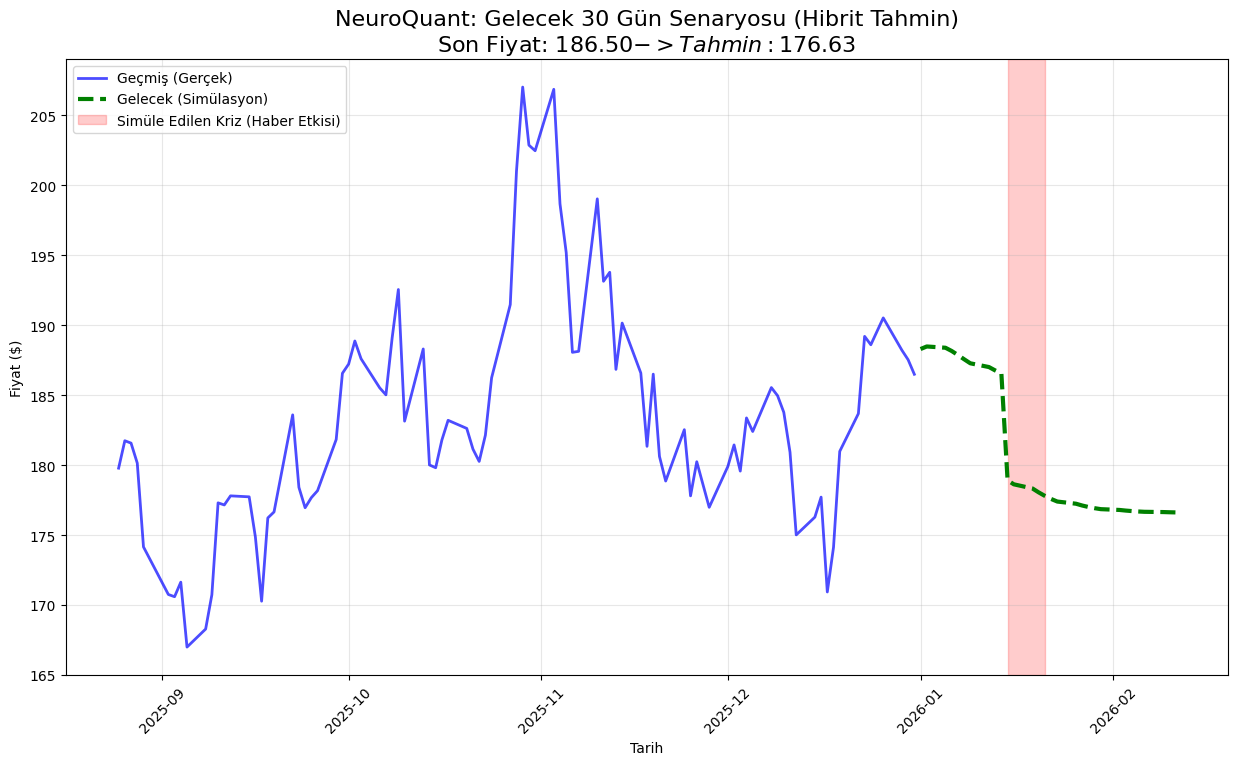

🏁 Simülasyon Bitiş Fiyatı: 176.63$
📉 Yorum: Kriz haberleri simülasyonu aşağı çekti. Sistem güvenli çalışıyor.


In [10]:
# =============================================================================
# BLOK 5: GELECEK HARİTASI (ZAMAN YOLCULUĞU GRAFİĞİ)
# =============================================================================
import matplotlib.pyplot as plt

print("🎨 Gelecek haritası çiziliyor...")

# 1. Verileri Hazırla
# Geçmişten son 90 günü alalım ki bağlantıyı görelim
history_days = 90
past_dates = df.index[-history_days:]
past_prices = df['Close'].iloc[-history_days:].values

# Gelecek 30 gün için sanal tarihler oluştur (İş günleri)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='B')

# 2. Grafiği Çiz
plt.figure(figsize=(15, 8))

# A. Geçmiş (Gerçekler)
plt.plot(past_dates, past_prices, label='Geçmiş (Gerçek)', color='blue', linewidth=2, alpha=0.7)

# B. Gelecek (Simülasyon)
# Bağlantı kopuk olmasın diye geçmişin son noktasıyla geleceğin ilk noktasını birleştiren bir çizgi ekleyebiliriz
# Ama şimdilik direkt çizelim.
plt.plot(future_dates, future_prices, label='Gelecek (Simülasyon)', color='green', linewidth=3, linestyle='--')

# C. Olay İşaretleme (Kriz Dönemi)
# Gün 10-15 arası kriz vardı (Index 10-15)
# Grafikte o bölgeyi kırmızıyla boyayalım
plt.axvspan(future_dates[10], future_dates[14], color='red', alpha=0.2, label='Simüle Edilen Kriz (Haber Etkisi)')

# Süslemeler
plt.title(f"NeuroQuant: Gelecek 30 Gün Senaryosu (Hibrit Tahmin)\nSon Fiyat: {past_prices[-1]:.2f}$ -> Tahmin: {future_prices[-1]:.2f}$", fontsize=16)
plt.xlabel("Tarih")
plt.ylabel("Fiyat ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.show()

print(f"🏁 Simülasyon Bitiş Fiyatı: {future_prices[-1]:.2f}$")
if future_prices[-1] < past_prices[-1]:
    print("📉 Yorum: Kriz haberleri simülasyonu aşağı çekti. Sistem güvenli çalışıyor.")
else:
    print("📈 Yorum: Pozitif hava galip geldi.")